In [70]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import random
pd.set_option("display.max_rows", None)  # Shows all rows in a DataFrame
pd.set_option("display.max_columns", None)  # Shows all columns in a DataFrame

# hv.renderer('bokeh').theme = 'dark_minimal'

In [71]:
# dataset_root = Path(r"C:\Users\Raffael\Documents\Datasets\alpiq_2023") # Raw string works without escaping \
# dataset_root = Path(r"C:/Users/jadbh\Documents/Swisse/EPFL/courses/Fall 2024/Machine Learning for Predictive Maintenance/project/Dataset")
# dataset_root = Path(r"C:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\project\team repo\Machine-Learning-for-Predictive-Maintenance-project\Dataset")
dataset_root = Path(r'Dataset')

@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=False, load_training=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=False, load_training=True)

In [72]:
parquet_file_path = dataset_root / "synthetic_anomalies" / "VG5_anomaly_01_type_c.parquet"
vg5_s1 = pd.read_parquet(parquet_file_path)

In [73]:
vg5_train_meas = rds_u5.data_dict["train"].measurements
vg5_train_info = rds_u5.data_dict["train"].info

In [74]:
vg5_train_meas.reset_index(inplace=True)
vg5_train_filt_pump = vg5_train_meas [(vg5_train_meas['equilibrium_short_circuit_mode'] == True)]
    # (vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['dyn_only_on'] == False) ]
                                        #    (vg5_train_meas['equilibrium_turbine_mode'] == True)] 
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

df = vg5_train_filt_pump

In [75]:
vg5_s1.reset_index(inplace=True)

In [76]:
print("OG columns: ", df.columns.to_list())
print("OG columns length: ", len(df.columns.to_list()))
df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df.drop(['index'], axis = 1, inplace=True)
df.drop(columns= df.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)
print("final columns:       ", df.columns.to_list())
print("final columns lengthL", len(df.columns.to_list()))
# df.sample(3)


OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

C:\Users\jadbh\AppData\Local\Temp\ipykernel_21328\2495774555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\jadbh\AppData\Local\Temp\ipykernel_21328\2495774555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis = 1, inplace=True)
C:\Users\jadbh\AppData\Local\Temp\ipykernel_21328\2495774555.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [77]:
df_test = vg5_s1.copy()

print("OG columns: ", df_test.columns.to_list())
print("OG columns length: ", len(df_test.columns.to_list()))
df_test.drop(['ground_truth'], axis = 1, inplace=True)
df_test.drop(columns=df_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df_test.drop(['index'], axis = 1, inplace=True)
df_test.drop(columns= df_test.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)
print("final columns:       ", df_test.columns.to_list())
print("final columns lengthL", len(df_test.columns.to_list()))
# df_test.sample(3)

OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

In [78]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, feature_columns, window_size, step_size=1, max_gap=10, stride = 2):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing sensor data.
            feature_columns (list): List of column names for features.
            window_size (int): The number of timesteps in each sliding window.
            step_size (int): The step size to slide the window.
            max_gap (int): Maximum allowed gap between consecutive indices for grouping.
        """
        self.features = dataframe[feature_columns].values
        self.indices = dataframe.index.values
        self.window_size = window_size
        self.step_size = step_size
        self.max_gap = max_gap
        self.stride = stride

        # Identify groups based on index gaps
        self.groups = self._identify_groups()
        # print(self.groups[0:50])
        # print(len(self.groups[500]))
        self.valid_windows = self._generate_valid_windows()

    def _identify_groups(self):
        """
        Identify groups of rows based on the max_gap condition.
        """
        groups = []
        current_group = [0]  # Start with the first row
        for i in range(1, len(self.indices)):
            if self.indices[i] - self.indices[i - 1] > self.max_gap:
                groups.append(current_group)
                current_group = [i]
            else:
                current_group.append(i)
        groups.append(current_group)  # Add the last group
        return groups

    def _generate_valid_windows(self):
        """
        Generate valid sliding windows based on groups.
        """
        valid_windows = []
        for group in self.groups:
            
            for start in range(0, len(group) - self.window_size + 1, self.stride):
                valid_windows.append(group[start : start + self.window_size])

            if (len(group) - self.window_size)%self.stride != 0 and len(group)> self.window_size:
                # print(len(group[len(group) - self.window_size : len(group)]))
                valid_windows.append(group[len(group) - self.window_size : len(group)])

        # print(valid_windows[-1])
        return valid_windows

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        """
        Retrieve a sliding window by index.
        """
        window_indices = self.valid_windows[idx]
        x = torch.tensor(self.features[window_indices], dtype=torch.float32)
        original_indices = self.indices[window_indices] 
        return x

feature_columns = df.columns

feature_columns_test = df_test.columns
# feature_columns = ["charge"]
# feature_columns = df.columns.to_string()
window_size = 1000
stride = 100
max_gap = 1000
batch_size = 32
step_size = stride  # Step size for sliding window

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle = False)
print("Total df shape:", df.shape)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Total df shape: (105952, 84)
Training set shape: (84761, 84)
Testing set shape: (21191, 84)


train dataloader length:  12
train dataloader dataset length:  367
test dataloader length:  4
test dataloader dataset length:  123
Total windows: 367
Total number of groups: 183
Average points per group: 463.1748633879781
Minimum group size: 1


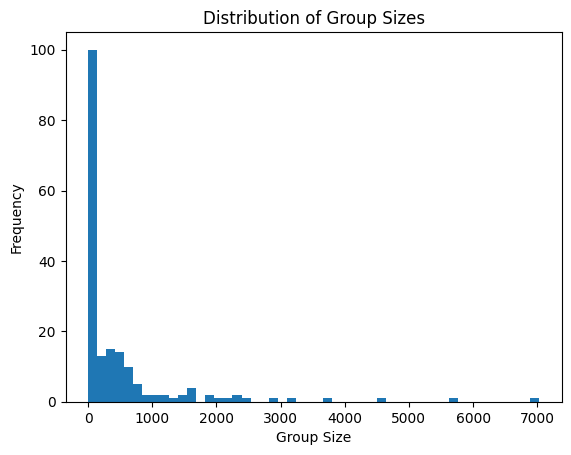

In [79]:
# Example dataset setup
# Assuming `df` is already defined
window_size = 1000
stride = 100
max_gap = 1000
batch_size = 32
step_size = stride  # Step size for sliding window

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Here I am using the old scaling again, we can use the prints in a presentation or something

# Initialize a scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(train_df[feature_columns])

# Transform the training and testing data
train_df[feature_columns] = scaler.transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])
df_test[feature_columns_test] = scaler.transform(df_test[feature_columns_test])  #synthetic anomalies


# Create Dataset and DataLoader
train_dataset = SlidingWindowDataset(train_df, feature_columns, window_size, step_size, max_gap, stride = stride)
test_dataset = SlidingWindowDataset(test_df, feature_columns, window_size, step_size, max_gap, stride = stride)
synth_test =  SlidingWindowDataset(df_test, feature_columns, window_size, step_size, max_gap, stride = stride)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
synth_test_loader = DataLoader(synth_test, batch_size=batch_size, shuffle=False)

print("train dataloader length: ", len(train_dataloader))
print("train dataloader dataset length: ", len(train_dataloader.dataset))

print("test dataloader length: ", len(test_dataloader))
print("test dataloader dataset length: ", len(test_dataloader.dataset))

print(f"Total windows: {len(train_dataset)}")
print(f"Total number of groups: {len(train_dataset.groups)}")
print(f"Average points per group: {np.mean([len(group) for group in train_dataset.groups])}")
group_sizes = [len(group) for group in train_dataset.groups]
print(f"Minimum group size: {min(group_sizes)}")
plt.hist(group_sizes, bins=50)
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.title('Distribution of Group Sizes')
plt.show()

In [80]:
def custom_loss(x, x_reconstructed, encoded, sparsity_weight=1e-3):
    """
    Combines reconstruction loss with a sparsity constraint on the latent space.
    Args:
        x (torch.Tensor): Original input tensor.
        x_reconstructed (torch.Tensor): Reconstructed tensor.
        encoded (torch.Tensor): Latent representation.
        sparsity_weight (float): Weight for the sparsity penalty.
    Returns:
        torch.Tensor: Combined loss.
    """
    reconstruction_loss = nn.MSELoss()(x_reconstructed, x)
    sparsity_loss = torch.mean(torch.abs(encoded))  # L1 penalty for sparsity
    return reconstruction_loss + sparsity_weight * sparsity_loss


In [81]:
class ResidualConvAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_len):
        super(ResidualConvAutoencoder, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([256, seq_len]),
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//4])
        )
        self.encoder_pool = nn.MaxPool1d(2)  # Down-sampling at each stage

        # Latent space (larger latent space)
        self.latent = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),  # Additional latent layer
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//8])
        )

        # Decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose1d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//4])
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose1d(64+64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose1d(128+128, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([256, seq_len])
        )
        self.output_layer = nn.Sequential(
            nn.Conv1d(256+256, input_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Ensures output is in the range [0, 1]
        )

    def forward(self, x):
        """
        Forward pass with residual connections and latent space.
        """
        # Encoder
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        skip1 = self.encoder_conv1(x)  # First layer output for skip connection
        # print("ENCODER LAYER: 1",skip1.shape)
        skip2 = self.encoder_conv2(self.encoder_pool(skip1))  # Second layer output for skip
        # print("ENCODER LAYER: 2",skip2.shape)
        encoded = self.encoder_conv3(self.encoder_pool(skip2))  # Latent input
        # print("ENCODER LAYER: 3",encoded.shape)
        latent = self.latent(self.encoder_pool(encoded))  # Latent representation
        # print("ENCODER LAYER: 4",latent.shape)

        # Decoder
        decoded = self.decoder_conv1(latent)
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded, encoded), dim=1)  # Align dimensions for skip connection
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = self.decoder_conv2(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip2), dim=1)  # Align dimensions for skip connection
        decoded = self.decoder_conv3(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip1), dim=1)  # Align dimensions for skip connection
        decoded = self.output_layer(decoded)  # Final reconstruction
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        # Revert to (batch_size, seq_len, features)
        return decoded.permute(0, 2, 1), latent


In [82]:
class ResidualConvAutoencoder_new(nn.Module):
    def __init__(self, input_dim, seq_len):
        super(ResidualConvAutoencoder_new, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len]),
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//2]),
            nn.Dropout(p=0.25)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([32, seq_len//4]),
            nn.Dropout(p=0.25)
        )
        self.encoder_pool = nn.MaxPool1d(2)  # Down-sampling at each stage

        # Latent space (larger latent space)
        self.latent = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1),  # Additional latent layer
            nn.ReLU(),
            nn.LayerNorm([32, seq_len//8])
        )

        # Decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([32, seq_len//4])
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose1d(32+32, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose1d(64+64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len]),
            nn.Dropout(p=0.25)
        )
        self.output_layer = nn.Sequential(
            nn.Conv1d(128+128, input_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Ensures output is in the range [0, 1]
        )

    def forward(self, x):
        """
        Forward pass with residual connections and latent space.
        """
        # Encoder
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        skip1 = self.encoder_conv1(x)  # First layer output for skip connection
        # print("ENCODER LAYER: 1",skip1.shape)
        skip2 = self.encoder_conv2(self.encoder_pool(skip1))  # Second layer output for skip
        # print("ENCODER LAYER: 2",skip2.shape)
        encoded = self.encoder_conv3(self.encoder_pool(skip2))  # Latent input
        # print("ENCODER LAYER: 3",encoded.shape)
        latent = self.latent(self.encoder_pool(encoded))  # Latent representation
        # print("ENCODER LAYER: 4",latent.shape)

        # Decoder
        decoded = self.decoder_conv1(latent)
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded, encoded), dim=1)  # Align dimensions for skip connection
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = self.decoder_conv2(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip2), dim=1)  # Align dimensions for skip connection
        decoded = self.decoder_conv3(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip1), dim=1)  # Align dimensions for skip connection
        decoded = self.output_layer(decoded)  # Final reconstruction
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        # Revert to (batch_size, seq_len, features)
        return decoded.permute(0, 2, 1), latent

In [83]:
def train_loop(dataloader, model, optimizer, noise_factor=0.1, sparsity_weight=1e-3):
    model.train()
    total_loss = 0

    for x in tqdm(dataloader):
        optimizer.zero_grad()

        # Add noise to input
        # noisy_x = add_noise(x, noise_factor)

        # Forward pass
        reconstructed, encoded = model(x) # because x is the batches and the indices

        # Compute loss
        loss = custom_loss(x, reconstructed, encoded, sparsity_weight)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def test_loop(dataloader, model, sparsity_weight=1e-3):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x in dataloader:
            reconstructed, encoded = model(x)
            loss = custom_loss(x, reconstructed, encoded, sparsity_weight)
            total_loss += loss.item()

    return total_loss / len(dataloader)



def set_seed(seed=42):
    """
    Set a constant seed for reproducibility across all libraries.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # Numpy
    torch.manual_seed(seed)  # PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids nondeterministic algorithms



In [84]:
set_seed(42)
# Hyperparameters
epochs = 50
learning_rate = 0.001
noise_factor = 0.1
sparsity_weight = 1e-3

# Model, optimizer, and dataloaders
input_dim = 84  # for pump, and 85 for turbine
seq_len = 1000
model = ResidualConvAutoencoder(input_dim, seq_len)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_evol, test_loss_evol = [], []

best_test_loss = float('inf')

In [85]:
# # TRAINING LOOP:
# # print(model)
# for epoch in range(epochs):
#     train_loss = train_loop(train_dataloader, model, optimizer, noise_factor, sparsity_weight)
#     test_loss = test_loop(test_dataloader, model, sparsity_weight)

#     print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {test_loss}")
#     train_loss_evol.append(train_loss)
#     test_loss_evol.append(test_loss)
#     if test_loss < best_test_loss:
#         best_test_loss = test_loss
#         patience_counter = 0  # Reset patience
#         torch.save(model.state_dict(), 'trying_model_VG5_pump.pth')  # Save the best model
#         print(f"New best model at epoch {epoch}")
#     # else:
#     #     patience_counter += 1
#     #     if patience_counter >= patience:
#     #         print(f"Early stopping at epoch {epoch}")
#     #         break


In [86]:
seq_len = 1000
model_turbine= ResidualConvAutoencoder(85, seq_len)
model_pump   = ResidualConvAutoencoder_new(84, seq_len)
model_scm    = ResidualConvAutoencoder(84, seq_len)

model_scm.load_state_dict(torch.load("best_model_VG5_SC.pth"))  # Load the trained model weights
model_scm.eval()  # Set the model to evaluation mode

model_pump.load_state_dict(torch.load("best_model_VG5_PUMP_v3.pth"))  # Load the trained model weights
model_pump.eval()  # Set the model to evaluation mode

# model_turbine.load_state_dict(torch.load("best_model_VG5_TURBINE.pth"))  # Load the trained model weights
model_turbine = torch.load("best_model_VG5_TURBINE.pth")
model_turbine.eval()  # Set the model to evaluation mode


C:\Users\jadbh\AppData\Local\Temp\ipykernel_21328\807081903.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_scm.load_state_dict(torch.load("best_model_VG5_SC.pth")

ResidualConvAutoencoder(
  (encoder_conv1): Sequential(
    (0): Conv1d(85, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((256, 1000), eps=1e-05, elementwise_affine=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((128, 500), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 250), eps=1e-05, elementwise_affine=True)
  )
  (encoder_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (latent): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 125), eps=1e-05, elementwise_affine=True)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose1d(64, 64, kernel_size=(2,), stride=(2,))
    

In [87]:
# # Access the first batch of the test dataloader
# from IPython.display import clear_output
# import time
# with torch.no_grad():
#     # print(len(synth_test_loader))
#     # Get the first batch from the dataloader
#     for x in synth_test_loader:
#         for i in range(len(x)):
#             clear_output(wait=True)
#         # x will have the shape (batch_size, seq_len, num_features)
#             # print("Batch shape:", x.shape)
#             # print(i)
            
#             # Use only the first element in the batch
#             x_sample = x[i].unsqueeze(0)  # Shape: (1, seq_len, num_features)

#             print("Single sample shape:", x_sample.shape)
            
#             # Pass it through the model
#             reconstructed, _ = model_pump(x_sample)
            
#             # Remove batch dimension for visualization
#             x_sample = x_sample.squeeze(0)  # Shape: (seq_len, num_features)
#             reconstructed = reconstructed.squeeze(0)  # Shape: (seq_len, num_features)
        
#             # Plot the original and reconstructed signal for one feature
#             feature_index = 2  # Adjust to visualize a specific feature
#             plt.plot(x_sample[:, feature_index].cpu().numpy(), label="Original")
#             plt.plot(reconstructed[:, feature_index].cpu().numpy(), label="Reconstructed")
#             plt.legend()
#             plt.title(f"Signal: {df.columns[feature_index]}")
#             plt.ylim([0,1])
#             plt.show()

            
                
#             # Break after first batch
            
#             # break


In [88]:
def plot_anomaly_detection(df,alarm_signal, reconstructed, reconstruction_error_evol, feature_name='plant_tmp', title="Anomaly Detection Results"):
    """
    Plot the results of anomaly detection including original data, anomalies, and ground truth.
    
    Args:
        df (pd.DataFrame): Original dataframe containing the features and ground truth labels.
        alarm_signal (list): Anomaly signal (1 for anomaly, 0 for normal) for each window.
        title (str): Title of the plot.
    """
    # Ensure the alarm signal aligns with the time range
    timestamps = df.index[:len(alarm_signal)]
    # reconstructed_timestamps = [t[0] for t in reconstructed]  # Timestamps of reconstructed signals
    # reconstructed_values = [t[1] for t in reconstructed]      # Reconstructed signal values

    # print(recon)

    # print(df['index'])
    
    # Plot
    plt.figure(figsize=(15, 12))
    
    # Plot anomalies
    plt.subplot(3, 1, 1)
    plt.plot(timestamps, alarm_signal, label="Anomaly Signal", color="red")
    plt.title(f"{title} - Anomalies")
    plt.xlabel("Time")
    plt.ylabel("Anomaly")
    plt.legend()

    # plt.subplot(3, 1, 3)
    # # for ts, reconstructed in zip(reconstructed_timestamps, reconstructed_values):
    # plt.plot(reconstructed_timestamps[0], reconstructed_values[0][:, df.columns.get_loc(feature_name)], label="Reconstructed Signal")
    # plt.title(f"Original vs Reconstructed Signal for {feature_name}")
    # plt.title(f"{title} - Recon signal")
    # plt.xlabel("Time")
    # plt.ylabel("recon_signal")
    
    
    # scaler.transform(df.iloc[:, 1:85].values)
    # Plot original data
    # df.reset_index(inplace=True)
    plt.subplot(3, 1, 2)
    # for column in df.columns:
    #     if column not in ["ground_truth"]:

    alpha = 1
    s = 0.2
    # start = int(np.random()*10000)
    # start = int(np.random*30)
    start = 2
    plt.scatter(df[df["equilibrium_pump_mode"]==True]['index'],df[df["equilibrium_pump_mode"]==True]['plant_tmp'], label='eq_pump', color ='red', alpha = alpha, s = s)
    # plt.scatter(df[df["equilibrium_turbine_mode"]==True]['index'],df[df["equilibrium_turbine_mode"]==True]['plant_tmp'], label='eq_turb', color ='blue', alpha = alpha, s = s)
    # plt.scatter(df[df["equilibrium_short_circuit_mode"]==True]['index'],df[df["equilibrium_short_circuit_mode"]==True]['plant_tmp'], label='eq_sc', color ='green', alpha = alpha, s = s)
    # plt.scatter(df['index'],df['plant_tmp'], label='eq_sc', color ='black', alpha = 0.05, s = s)

    # plt.scatter(df[df["turbine_mode"]==True]['index'],df[df["turbine_mode"]==True]['plant_tmp'], label='turb', color ='cyan', alpha = alpha, s = s)
    # plt.scatter(df[df["short_circuit_mode"]==True]['index'],df[df["short_circuit_mode"]==True]['plant_tmp'], label='sc', color ='yellow', alpha = alpha, s = s)

    # plt.plot(df2['index'],df2['plant_tmp'], label='plan_tmp')
    plt.title("Original Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc='upper right')

    plt.subplot(3, 1, 3)

    plt.plot(reconstruction_error_evol)
    plt.title("Reconstruction Error Evolution (sqrt)")
    plt.xlabel("Time Steps")
    plt.ylabel("Reconstruction Error")
    plt.grid()
    plt.show()

    start_date = datetime(2021, 6, start, 10, 0, 0)
    end_date = datetime(2021, 6, start, 18, 0, 0)
    # plt.xlim(start_date, end_date)

    plt.tight_layout()
    plt.show()


In [89]:
# first we test the model on the training data only on the associated points

def detect_anomalies_with_models_full_signal_specific_model(
    df, model, model_type, threshold, ground_truth, window_size=1000, stride=100,  device="cpu"
):
    """
    Detect anomalies at every timestep in a dataframe using autoencoder models.
    """

    scaler = MinMaxScaler()
    print(f"Normalizing the DataFrame... (shape: {df.shape})")
    print(f"columns: {list(df.columns)}")
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Extract the first column and the columns 90 through 100
    first_col = df.iloc[:, [0]]
    if not ground_truth:
        non_norm_cols = df.iloc[:, list(range(90, 100))]            # replace 100 with 101 for synthetic signal with ground truth
        df.drop(df.columns[[0] + list(range(90, 100))], axis=1, inplace=True)
    else: 
        non_norm_cols = df.iloc[:, list(range(90, 101))]
        df.drop(df.columns[[0] + list(range(90, 101))], axis=1, inplace=True)

    # Normalize the remaining columns
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Reintroduce the first extracted column as the first column
    df = pd.concat([first_col.reset_index(drop=True), df_normalized, non_norm_cols.reset_index(drop=True)], axis=1)

    print(f"Normalization done, shape: {df.shape}.")
    print(f"columns: {list(df.columns)}")
    
    alarm_signal_full = np.zeros(len(df), dtype=int)  # Full-length alarm signal
    reconstructed_signals = np.zeros(len(df), dtype=int)
    reconstruction_error_evol = []

    df_copy = df.copy()
    
    df_copy['injector_mean'] = df[['injector_01_opening', 'injector_02_opening', 
                                    'injector_03_opening', 'injector_04_opening', 
                                    'injector_05_opening']].mean(axis=1)
    
    df_copy.drop(columns= df_copy.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)


    for start_idx in range(0, len(df) - window_size + 1, stride):
        end_idx = start_idx + window_size
        window = df_copy.iloc[start_idx:end_idx].copy()
        window_timestamps = window['index']

        num_points_turbine = (window["equilibrium_turbine_mode"] == True).sum()
        num_points_pump = (window["equilibrium_pump_mode"] == True).sum()
        num_points_sc = (window["equilibrium_short_circuit_mode"] == True).sum()

        if max(num_points_turbine, num_points_pump, num_points_sc) > 60:        # minimum number of equilibrium points in the window
            if num_points_turbine >= num_points_pump and num_points_turbine >= num_points_sc:
                majority_mode = "turbine"
            elif num_points_pump >= num_points_turbine and num_points_pump >= num_points_sc:
                majority_mode = "pump"
            else:
                majority_mode = "sc"
        else:
            majority_mode = "skip"

        if majority_mode == model_type:     #pump or turbine or sc
            if model_type == "turbine":
                x = window.iloc[:, list(range(1, 85)) + [-1]]
                x = x.values
                x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
                model_turbine.eval()
                with torch.no_grad():
                    x_reconstructed, _ = model_turbine(x_tensor)
                x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()
                # reconstructed_signals[start_idx:end_idx] = x_reconstructed[:, 2]
                reconstruction_error = ((abs(x[:, 2] - x_reconstructed[:, 2])) ** 0.5).mean()
                reconstruction_error_evol.append(reconstruction_error)

            else:       # eiter pump or sc
                if "injector_mean" in window.columns:
                    window.drop(['injector_mean'], axis=1, inplace=True)
                x = window.iloc[:, 1:85].values
                # print("PUMP COLUMNS: ", x.columns)
                x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
                model.eval()
                with torch.no_grad():
                    x_reconstructed, _ = model(x_tensor)
                x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()
                # reconstructed_signals[start_idx:end_idx] = x_reconstructed[:, 2]
                reconstruction_error = ((abs(x[:, 2] - x_reconstructed[:, 2])) ** 0.5).mean()
                reconstruction_error_evol.append(reconstruction_error)

        else:       # skip mode
            reconstruction_error_evol.append(0)
            continue

        # Compute reconstruction error
        # reconstruction_error = ((x[:, 2] - x_reconstructed[:, 2]) ** 2).mean()

        # reconstruction_error_evol.append(reconstruction_error)
        
        # if reconstruction_error > threshold:
        #     alarm_signal_full[start_idx:end_idx] = 1  # Mark anomalies in full-length signal

    return alarm_signal_full.tolist(), reconstructed_signals, reconstruction_error_evol


In [90]:
def plot_reconstruction_error_per_mode_combined(df, ground_truth, feature_name='plant_tmp', title="Anomaly Detection Results"):
    """
    Plot the results of anomaly detection including original data, anomalies, and ground truth.
    
    Args:
        df (pd.DataFrame): Original dataframe containing the features and ground truth labels.
        alarm_signal (list): Anomaly signal (1 for anomaly, 0 for normal) for each window.
        title (str): Title of the plot.
    """

    print("... running pump model ...")
    _ , _ , reconstruction_error_evol_pump = detect_anomalies_with_models_full_signal_specific_model(
    df = df,
    model = model_pump, 
    model_type = "pump",     # pump or turbine or sc
    threshold=0.25,
    window_size=1000, 
    stride=window_size, 
    ground_truth = ground_truth,
    device="cuda" if torch.cuda.is_available() else "cpu"
)
    
    print("... running turbine model ...")
    _ , _ , reconstruction_error_evol_turbine = detect_anomalies_with_models_full_signal_specific_model(
    df = df,
    model = model_turbine, 
    model_type = "turbine",     # pump or turbine or sc
    threshold=0.25,
    window_size=1000, 
    stride=window_size, 
    ground_truth = ground_truth,
    device="cuda" if torch.cuda.is_available() else "cpu"
)
    print("... running sc model ...")
    _ , _ , reconstruction_error_evol_sc = detect_anomalies_with_models_full_signal_specific_model(
    df = df,
    model = model_scm, 
    model_type = "sc",     # pump or turbine or sc
    threshold=0.25,
    window_size=1000, 
    stride=window_size, 
    ground_truth = ground_truth,
    device="cuda" if torch.cuda.is_available() else "cpu"
)
    
    # timestamps = df.index[:len(alarm_signal)]

    # Plot
    plt.figure(figsize=(15, 12))

    plt.subplot(5, 1, 1)
 
    alpha = 1
    s = 0.2
    start = 2

    print('--plotting--')
    plt.scatter(df[df["equilibrium_pump_mode"]==True]['index'],df[df["equilibrium_pump_mode"]==True]['plant_tmp'], label='eq_pump', color ='red', alpha = alpha, s = s)
    plt.scatter(df[df["equilibrium_turbine_mode"]==True]['index'],df[df["equilibrium_turbine_mode"]==True]['plant_tmp'], label='eq_turb', color ='blue', alpha = alpha, s = s)
    plt.scatter(df[df["equilibrium_short_circuit_mode"]==True]['index'],df[df["equilibrium_short_circuit_mode"]==True]['plant_tmp'], label='eq_sc', color ='green', alpha = alpha, s = s)
    plt.scatter(df['index'],df['plant_tmp'], label='other', color ='black', alpha = 0.05, s = s)
    # plt.scatter(df[df["turbine_mode"]==True]['index'],df[df["turbine_mode"]==True]['plant_tmp'], label='turb', color ='cyan', alpha = alpha, s = s)
    # plt.scatter(df[df["short_circuit_mode"]==True]['index'],df[df["short_circuit_mode"]==True]['plant_tmp'], label='sc', color ='yellow', alpha = alpha, s = s)

    # plt.plot(df2['index'],df2['plant_tmp'], label='plan_tmp')
    plt.title("Original Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc='upper right')

    plt.subplot(5, 1, 2)

    plt.plot(reconstruction_error_evol_pump)
    plt.title("Reconstruction Error Evolution (sqrt) for Pump")
    plt.grid()

    plt.subplot(5, 1, 3)

    plt.plot(reconstruction_error_evol_turbine)
    plt.title("Reconstruction Error Evolution (sqrt) for Turbine")
    plt.grid()

    plt.subplot(5, 1, 4)

    plt.plot(reconstruction_error_evol_sc)
    plt.title("Reconstruction Error Evolution (sqrt) for Short Circuit")
    plt.grid()

    plt.subplot(5, 1, 5)
    combined_reconstruction_error = [
        pump + turbine + sc 
        for pump, turbine, sc in zip(reconstruction_error_evol_pump, reconstruction_error_evol_turbine, reconstruction_error_evol_sc)
]
    plt.plot(combined_reconstruction_error)
    plt.title("Reconstruction Error Evolution (sqrt) for sum of all")
    plt.grid()
    # plt.ylim([0, 0.9])

    start_date = datetime(2021, 6, start, 10, 0, 0)
    end_date = datetime(2021, 6, start, 18, 0, 0)
    plt.xlim(start_date, end_date)

    plt.tight_layout()
    plt.show()

... running pump model ...
Normalizing the DataFrame... (shape: (1047207, 100))
columns: ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage',

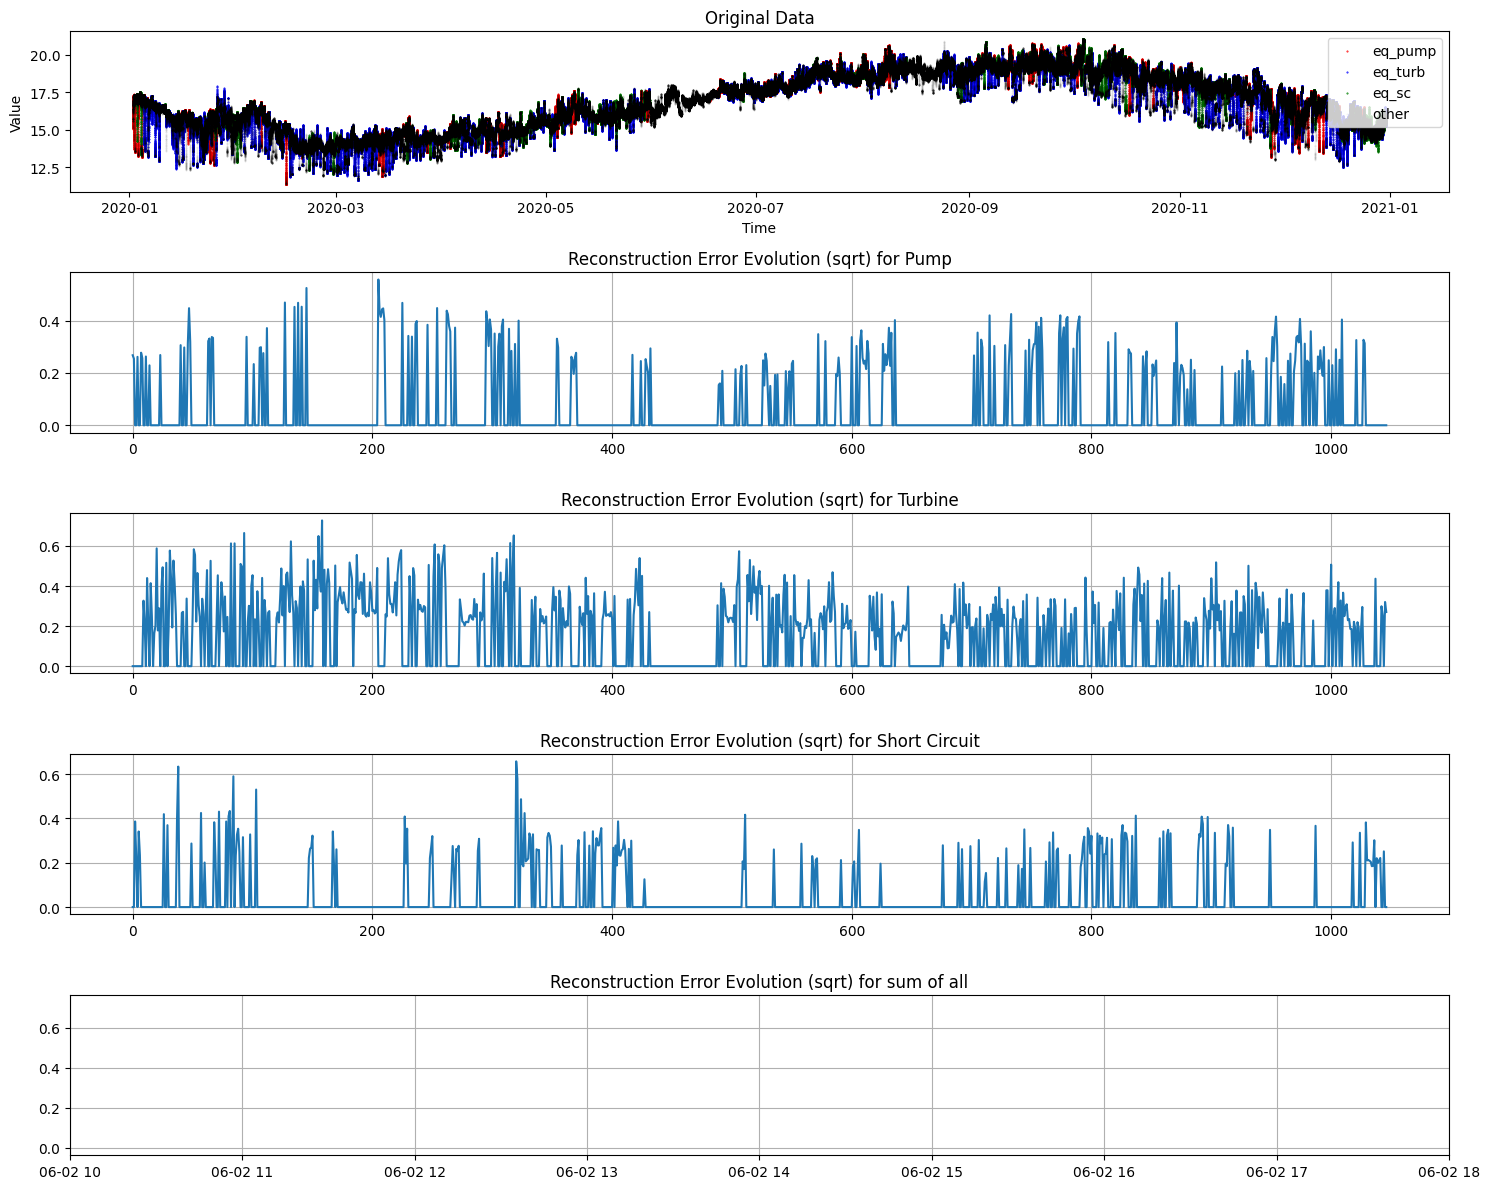

In [91]:
full_training_signal = rds_u5.data_dict["train"].measurements
plot_reconstruction_error_per_mode_combined(df = full_training_signal, ground_truth = False, title = "individual reconstruction errors for training data")

... running pump model ...
Normalizing the DataFrame... (shape: (172740, 101))
columns: ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 

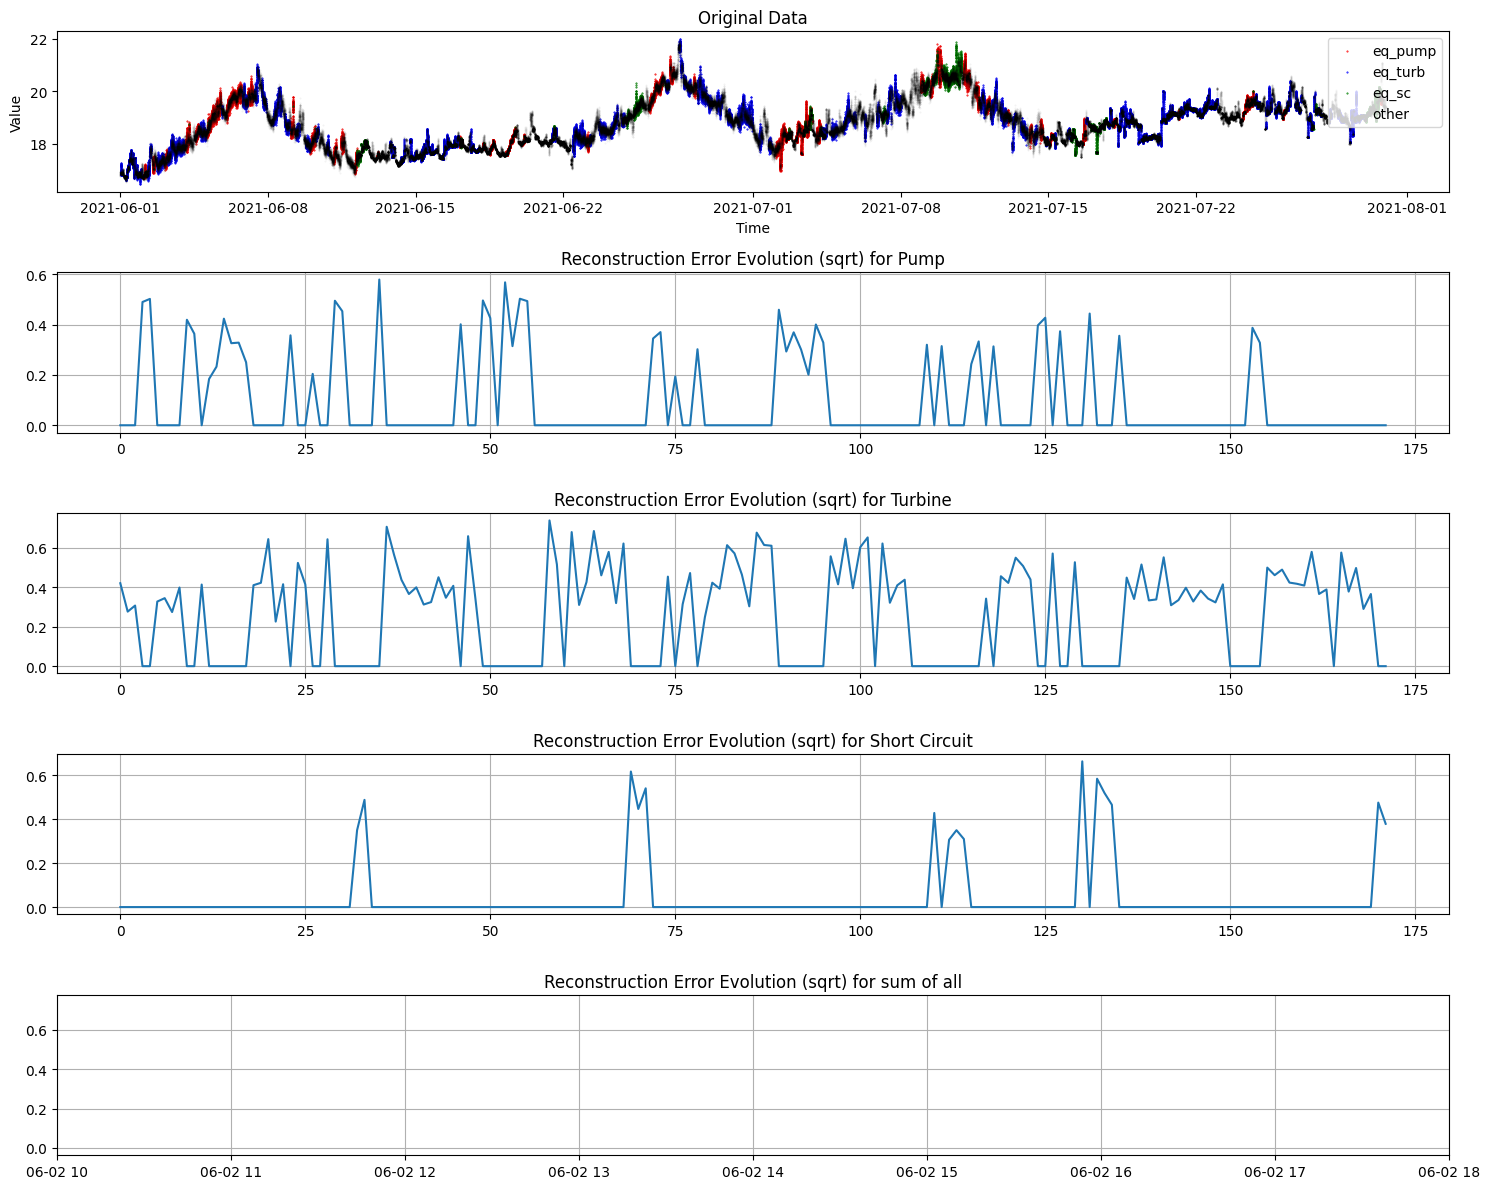

In [92]:
plot_reconstruction_error_per_mode_combined(df = vg5_s1, ground_truth = True, title = "individual reconstruction errors for testing data")

In [93]:

# alarm_signal, recon_signals, reconstruction_error_evol = detect_anomalies_with_models_full_signal_specific_model(
#     df = full_training_signal,
#     model = model_pump, 
#     model_type = "pump",     # pump or turbine or sc
#     threshold=0.25,
#     window_size=1000, 
#     stride=window_size, 
#     device="cuda" if torch.cuda.is_available() else "cpu"
# )
# print("plotting...")
# plot_anomaly_detection(full_training_signal, alarm_signal, recon_signals, reconstruction_error_evol = reconstruction_error_evol, title="VG5 Anomaly Detection")

In [94]:
# alarm_signal, recon_signals, reconstruction_error_evol = detect_anomalies_with_models_full_signal_specific_model(
#     df = full_training_signal,
#     model = model_turbine, 
#     model_type = "turbine",     # pump or turbine or sc
#     threshold=0.25,
#     window_size=1000, 
#     stride=window_size, 
#     device="cuda" if torch.cuda.is_available() else "cpu"
# )
# print("plotting...")
# plot_anomaly_detection(full_training_signal, alarm_signal, recon_signals, reconstruction_error_evol = reconstruction_error_evol, title="VG5 Anomaly Detection")

In [95]:
# alarm_signal, recon_signals, reconstruction_error_evol = detect_anomalies_with_models_full_signal_specific_model(
#     df = full_training_signal,
#     model = model_scm, 
#     model_type = "sc",     # pump or turbine or sc
#     threshold=0.25,
#     window_size=1000, 
#     stride=window_size, 
#     device="cuda" if torch.cuda.is_available() else "cpu"
# )
# print("plotting...")
# plot_anomaly_detection(full_training_signal, alarm_signal, recon_signals, reconstruction_error_evol = reconstruction_error_evol, title="VG5 Anomaly Detection")

In [96]:
def detect_anomalies_with_models_full_signal(
    df, model_turbine, model_pump, model_scm, threshold, window_size=1000, stride=100, device="cpu"
):
    """
    Detect anomalies at every timestep in a dataframe using autoencoder models.
    """

    scaler = MinMaxScaler()
    print(f"Normalizing the DataFrame... (shape: {df.shape})")
    print(f"columns: {list(df.columns)}")
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Extract the first column and the columns 90 through 100
    first_col = df.iloc[:, [0]]
    non_norm_cols = df.iloc[:, list(range(90, 101))]

    # Drop the extracted columns from the original DataFrame
    df.drop(df.columns[[0] + list(range(90, 101))], axis=1, inplace=True)

    # Normalize the remaining columns
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Reintroduce the first extracted column as the first column
    df = pd.concat([first_col.reset_index(drop=True), df_normalized, non_norm_cols.reset_index(drop=True)], axis=1)

    print(f"Normalization done, shape: {df.shape}.")
    print(f"columns: {list(df.columns)}")
    
    alarm_signal_full = np.zeros(len(df), dtype=int)  # Full-length alarm signal
    reconstructed_signals = []
    df_copy = df.copy()
    df_copy1 = df.copy()
    
    df_copy['injector_mean'] = df[['injector_01_opening', 'injector_02_opening', 
                                    'injector_03_opening', 'injector_04_opening', 
                                    'injector_05_opening']].mean(axis=1)
    
    df_copy.drop(columns= df_copy.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)

    reconstruction_error_evol = []

    for start_idx in range(0, len(df) - window_size + 1, stride):
        end_idx = start_idx + window_size
        window = df_copy.iloc[start_idx:end_idx].copy()
        window_timestamps = window['index']

        num_points_turbine = (window["equilibrium_turbine_mode"] == True).sum()
        num_points_pump = (window["equilibrium_pump_mode"] == True).sum()
        num_points_sc = (window["equilibrium_short_circuit_mode"] == True).sum()

        if max(num_points_turbine, num_points_pump, num_points_sc) > 60:        # minimum number of equilibrium points in the window
            if num_points_turbine >= num_points_pump and num_points_turbine >= num_points_sc:
                majority_mode = "turbine"
            elif num_points_pump >= num_points_turbine and num_points_pump >= num_points_sc:
                majority_mode = "pump"
            else:
                majority_mode = "sc"
        else:
            majority_mode = "skip"

        if majority_mode == "turbine":  
            x = window.iloc[:, list(range(1, 85)) + [-1]]
            x = x.values
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            model_turbine.eval()
            with torch.no_grad():
                x_reconstructed, _ = model_turbine(x_tensor)
            x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()
            reconstruction_error = (abs((x[:, 2] - x_reconstructed[:, 2])) ** 0.5).mean()
            reconstruction_error_evol.append(reconstruction_error)

        elif majority_mode == "pump":  
            if "injector_mean" in window.columns:
                window.drop(['injector_mean'], axis=1, inplace=True)
            # x = scaler.fit_transform(window.iloc[:, 1:85].values)
            x = window.iloc[:, 1:85].values
            # print("PUMP COLUMNS: ", x.columns)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            model_pump.eval()
            with torch.no_grad():
                x_reconstructed, _ = model_pump(x_tensor)
            x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()
            reconstruction_error = (abs((x[:, 2] - x_reconstructed[:, 2])) ** 0.5).mean()
            reconstruction_error_evol.append(reconstruction_error)

        elif majority_mode == "sc":  
            # x = scaler.fit_transform(window.iloc[:, 1:85].values)
            x = window.iloc[:, 1:85].values
            # print("SC COLUMNS: ", x.columns)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            model_scm.eval()
            with torch.no_grad():
                x_reconstructed, _ = model_scm(x_tensor)
            x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()
            reconstruction_error = (abs((x[:, 2] - x_reconstructed[:, 2])) ** 0.5).mean()
            reconstruction_error_evol.append(reconstruction_error)

        else:
            reconstruction_error_evol.append(0)
            continue  # Skip the window if none of the conditions are met

        reconstructed_signals.append((window_timestamps, x_reconstructed))
    
        if reconstruction_error > threshold:
            alarm_signal_full[start_idx:end_idx] = 1  # Mark anomalies in full-length signal

    return alarm_signal_full.tolist(), reconstructed_signals, reconstruction_error_evol

In [97]:
# Assuming `df_complete_synth_test` is your synthetic dataframe and models are preloaded
# df_an =df_an.reset_index(inplace=True)
alarm_signal, recon_signals, reconstruction_error_evol = detect_anomalies_with_models_full_signal(
    vg5_s1, 
    model_turbine, 
    model_pump, 
    model_scm, 
    threshold=0.25,
    window_size=1000, 
    stride=window_size,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

Normalizing the DataFrame... (shape: (172740, 101))
columns: ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_

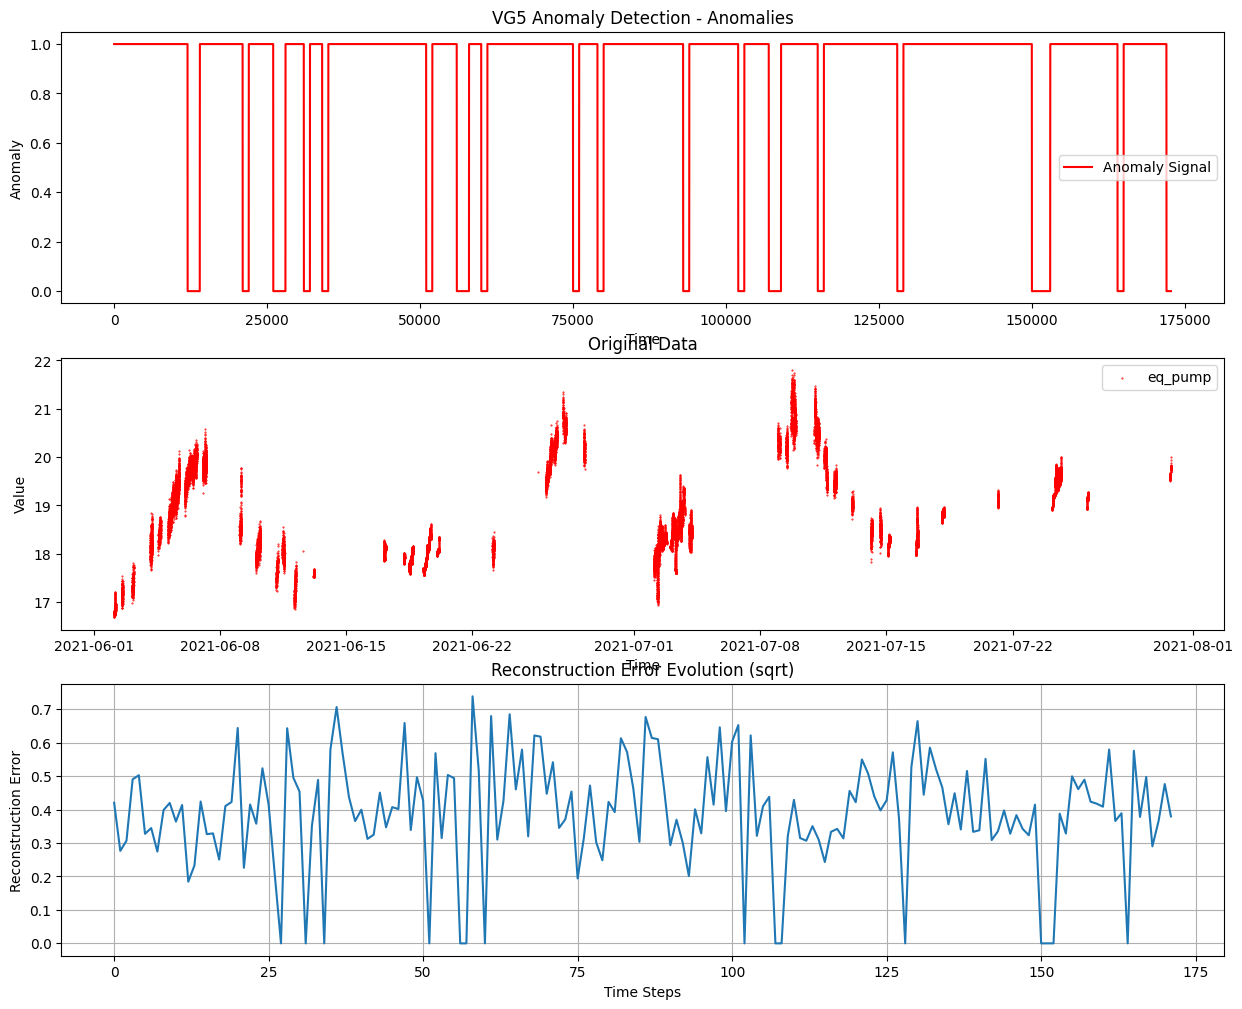

<Figure size 640x480 with 0 Axes>

In [98]:
plot_anomaly_detection(vg5_s1, alarm_signal, recon_signals, reconstruction_error_evol = reconstruction_error_evol, title="VG5 Anomaly Detection")